In [1]:
%matplotlib inline

import cv2 # The OpenCV library; install using `pip install opencv-contrib-python`
import numpy as np # Helpful when working with arrays; install using `pip install numpy`
from matplotlib import pyplot as plt # Good for graphing; install using `pip install matplotlib`
from matplotlib import image as image
import easygui # An easy-to-use file-picker; pip install easygui (mac not supported)

In [2]:
# get background subtractor
sub_type = 'KNN' # 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    # backSub.setShadowThreshold(0.75)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

Text(0.5, 1.0, 'KNN Foreground Mask after 5 frames')

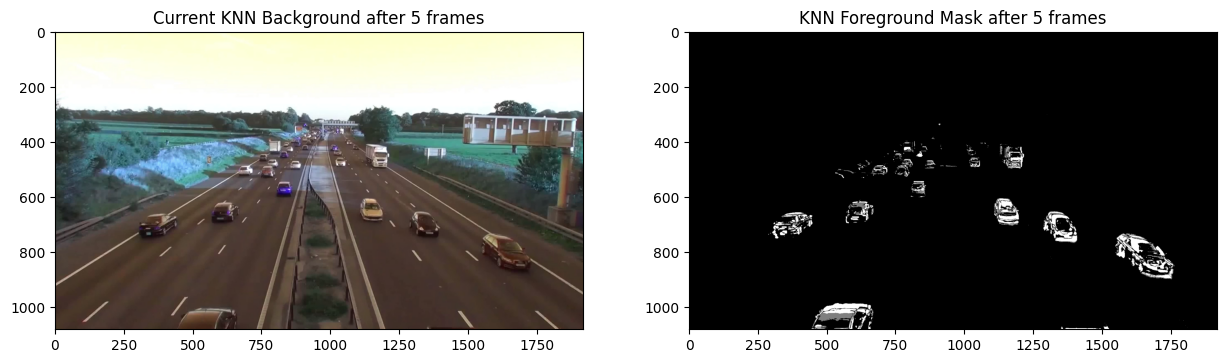

In [3]:
video = cv2.VideoCapture("Images/traffic.mp4")

image_paths = []

# read the first 5 frames
for i in range(5):
    ret, frame = video.read()
    fg_mask = backSub.apply(frame)


# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray') 
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")

In [4]:
def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask


In [5]:
def get_contour_detections(mask, thresh=400):
    # get mask contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: 
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

def remove_contained_bboxes(boxes):
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

def get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=np.array((9,9), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            backSub - Background Subtraction Model
            frame - Current BGR Frame
            bbox_thresh - Minimum threshold area for declaring a bounding box
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # Update Background Model and get foreground mask
    fg_mask = backSub.apply(frame)

    # get clean motion mask
    motion_mask = get_motion_mask(fg_mask, kernel=kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # Check if detections are not empty and have the expected shape
    if detections is None or len(detections) == 0:
        return np.array([])  # Return an empty array if there are no detections
    
    # Make sure detections is a 2D array
    detections = np.atleast_2d(detections)
    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, nms_thresh)

Text(0.5, 1.0, 'KNN Foreground Mask after 5 frames')

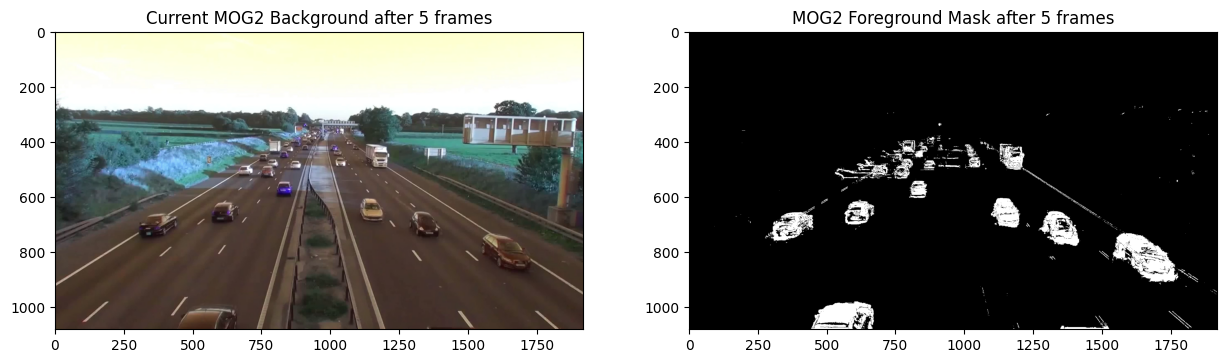

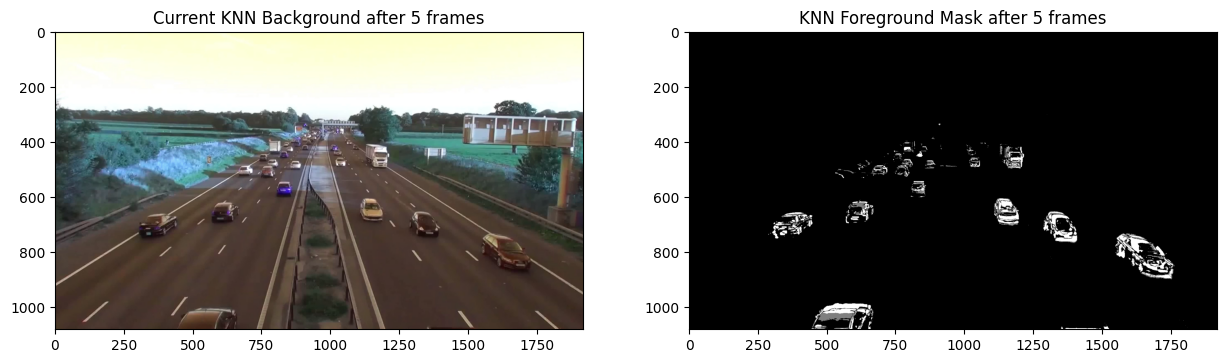

In [6]:
kernel=np.array((9,9), dtype=np.uint8)


sub_type = 'MOG2' # 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)


video = cv2.VideoCapture("Images/traffic.mp4")

# read the first 5 frames
for i in range(5):
    ret, frame = video.read()
    fg_mask = backSub.apply(frame)

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray')
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")

# get detections
detections = get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=kernel)


sub_type = 'KNN' # 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

video = cv2.VideoCapture("Images/traffic.mp4")

# read the first 5 frames
for i in range(5):
    ret, frame = video.read()
    fg_mask = backSub.apply(frame)
    
# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray')
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")




In [8]:
# KNN

video = cv2.VideoCapture("Images/traffic.mp4")

sub_type = 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    
while True:
    ret, frame = video.read()
    if frame is None:
        break
    detections = get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=kernel)
    for x1, y1, x2, y2 in detections:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow("Detections", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()



In [ ]:
# MOG2 (MOG2 picks up a lot more and is more sensitive to noise)

video = cv2.VideoCapture("Images/traffic.mp4")

sub_type = 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    
while True:
    ret, frame = video.read()
    if frame is None:
        break
    detections = get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=kernel)
    for x1, y1, x2, y2 in detections:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow("Detections", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

